In [5]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO
from torch.utils.data import WeightedRandomSampler
from torchvision.models import vgg16_bn
import sys
sys.path.append("..")
from Net.CNN import Net

In [6]:
data_flag = 'dermamnist'
NUM_EPOCHS = 10
BATCH_SIZE = 32
lr = 0.001
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = info['label']
DataClass = getattr(medmnist, info['python_class'])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#Mode is to define experiment. Mode=1 experiment with crossentropy . Mode=2 experiment with focal loss
mode=2
#Mode_model is to define model experiment. Mode=1 the model used is VGG16 and mode=2 the model used is CNN
mode_model=2
#mode_weightrandomsampler is to define if we use weightrandomsampler. 1 yes 2 no
mode_weightrandomsampler=2

In [7]:
if mode_model==1:
    data_transform = transforms.Compose([
        transforms.Resize((64,64)),                    #Descomentar en caso de usar modelo VGG y comentar en caso de usar CNN
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    data_test_transform = transforms.Compose([
        transforms.Resize((64,64)),                     #Descomentar en caso de usar modelo VGG y comentar en caso de usar CNN
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
else:
    print("Mode 2")
    data_transform = transforms.Compose([
        
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    data_test_transform = transforms.Compose([
       
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=True)
test_dataset = DataClass(split='test', transform=data_test_transform, download=True)
val_dataset = DataClass(split='val',transform=data_test_transform, download=True)

Mode 2
Using downloaded and verified file: C:\Users\ortiz\.medmnist\dermamnist.npz
Using downloaded and verified file: C:\Users\ortiz\.medmnist\dermamnist.npz
Using downloaded and verified file: C:\Users\ortiz\.medmnist\dermamnist.npz


In [4]:
def sampler_weight(datasets):
  N = len(datasets)
  N0 = 0
  N1 = 0
  N2 = 0
  N3 = 0
  N4 = 0
  N5 = 0
  N6 = 0

  for i, j in datasets:
    for x in j:
      if x.item() == 0:
        N0 += 1
      if x.item() == 1:
        N1 += 1
      if x.item() == 2:
        N2 += 1
      if x.item() == 3:
        N3 += 1
      if x.item() == 4:
        N4 += 1
      if x.item() == 5:
        N5 += 1
      if x.item() == 6:
        N6 += 1  

  class_weights = [N/N0, N/N1, N/N2, N/N3, N/N4, N/N5, N/N6]
  sample_weights = [0] * len(train_dataset)
  for id , (data, targets) in enumerate(datasets):
    class_weight = class_weights[targets.item()]
    sample_weights[id] = class_weight

  sampler = WeightedRandomSampler(sample_weights , num_samples=N , replacement=True)
  return sampler

In [5]:
if mode_weightrandomsampler==1:
    print('sampler_weight')
    train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False,sampler=sampler_weight(train_dataset))
else:
    train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_loader_at_eval = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [6]:
class FocalLoss(nn.Module):
  def __init__(self, alpha=0.25, gamma=2, size_average = True):
    super(FocalLoss, self).__init__()
    self.size_average = size_average
    #puede que haya que mandar alpha a device
    self.alpha = alpha
    self.gamma = torch.Tensor([gamma])
    if isinstance(alpha, (float, int)):
      if self.alpha > 1:
        raise ValueError('Not supported value, alpha should be small than 1.0')
      else:
        self.alpha = torch.Tensor([alpha, alpha,alpha, alpha,alpha, alpha,alpha])
    if isinstance(alpha, list): self.alpha = torch.Tensor(alpha)
    self.alpha /= torch.sum(self.alpha)

  def forward(self, input, target):
    input= torch.softmax(input,dim=1)
    if input.dim() > 2:
      input = input.view(input.size(0), input.size(1), -1)
      if self.alpha.device != input.device:
            self.alpha = torch.tensor(self.alpha, device=input.device)
    target = target.view(-1, 1)
    logpt = torch.log(input + 1e-10)
    logpt = logpt.gather(1, target)
    logpt = logpt.view(-1, 1)
    pt = torch.exp(logpt)
    alpha = self.alpha.gather(0, target.view(-1))
 
    gamma = self.gamma
 
    if not self.gamma.device == input.device:
      gamma = torch.tensor(self.gamma, device=input.device)
 
    loss = -1 * alpha * torch.pow((1 - pt), gamma) * logpt
    if self.size_average:
      loss = loss.mean()
    else:
      loss = loss.sum()
    return loss

In [7]:
def data_weight(datasets):
  N = len(datasets)
  N0 = 0
  N1 = 0
  N2 = 0
  N3 = 0
  N4 = 0
  N5 = 0
  N6 = 0

  for i, j in datasets:
    for x in j:
      if x.item() == 0:
        N0 += 1
      if x.item() == 1:
        N1 += 1
      if x.item() == 2:
        N2 += 1
      if x.item() == 3:
        N3 += 1
      if x.item() == 4:
        N4 += 1
      if x.item() == 5:
        N5 += 1
      if x.item() == 6:
        N6 += 1  

  class_weights = [N0/N, N1/N, N2/N, N3/N, N4/N, N5/N, N6/N]
  # class_weights = [N/N0, N/N1, N/N2, N/N3, N/N4, N/N5, N/N6]

  return class_weights

In [20]:

num_epochs=25
if mode_model==1:
     model=vgg16_bn().to(device)
else:
     model=Net(in_channels=n_channels, num_classes=n_classes).to(device)

optimizer = optim.SGD(model.parameters(), lr=0.0054802733399826895, momentum=0.8318708003341944)
if mode==1:
  criterion = nn.CrossEntropyLoss()
  print('crossentropy')
else:
  criterion = FocalLoss(alpha=0.4031422891026668 , gamma = 3.4208670578026905).to(device)
  criterion.alpha = criterion.alpha.to(device)
  print('focalloss')


#  tb_log = SummaryWriter('drive/MyDrive/log_Res_2022/test_PYTHON_VGG_weigthed_FOCALLOSS{}'.format(gamma))
for epoch in range(num_epochs):
    model.train()
  #   epoch_loss = []
    for idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        # forward + backward + optimize
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        if task == 'multi-label, binary-class':
                targets = targets.to(torch.int64)
                loss = criterion(outputs, targets)
        else:
                targets = targets.squeeze().long()
                loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
      

focalloss


  0%|          | 0/219 [00:00<?, ?it/s]C:\Users\ortiz\AppData\Local\Temp\ipykernel_6656\1762494115.py:32: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

100%|██████████| 219/219 [00:02<00:00, 107.23it/s]


In [21]:

model.eval()
with torch.no_grad():
  total=0.
  correct=0.
  for idx, (inputs, targets) in enumerate(tqdm(train_loader_at_eval)):
      inputs = inputs.to(device)
      targets = targets.to(device)
      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      if task == 'multi-label, binary-class':
              targets = targets.to(torch.int64)
      else:
              targets = targets.squeeze().long()
      total+=targets.size(0)
      correct += (predicted == targets).sum().item()
      
print(correct/total)


100%|██████████| 32/32 [00:00<00:00, 124.51it/s]

0.7477567298105683


In [22]:
from prettytable import PrettyTable
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import pandas as pd

class ConfusionMatrix(object):

  def __init__(self, num_classes: int, labels: list):
    self.matrix = np.zeros((num_classes,num_classes))
    self.num_classes = num_classes
    self.labels = labels

  def update(self, preds, labels):
    for p, t in zip(preds, labels):
      # p = p.astype(int)
      p = p.numpy().astype(int)
      t = t.astype(int)
      self.matrix[t,p] += 1

  def summary(self):
    #calcular accuracy
    sum_TP = 0
    for i in range(self.num_classes):
      sum_TP += self.matrix[i,i]
      
    acc = sum_TP/np.sum(self.matrix)
    print("The model accuracy is" , acc)

     #Presicion, recal, specificity
    table = PrettyTable()
    table.field_names = ["", "Presicion", "Recall", "Specificity","F-score"]

    for i in range (self.num_classes):
      TP = self.matrix[i,i]
      FP = np.sum(self.matrix[i, :]) - TP
      FN = np.sum(self.matrix[:, i]) - TP
      TN = np.sum(self.matrix) - TP - FP - FN

      Presicion = round(TP / (TP + FP), 3)
      Recall = round(TP / (TP + FN), 3)
      Specificity = round(TN / (TN + FP), 3)
      score = round((2*Presicion*Recall) / (Presicion+Recall),3)

      table.add_row([self.labels[i],Presicion,Recall,Specificity,score])
      
    print(table)
    
  def plot(self):
    matrix = self.matrix
    sumMatrix= []
    newMatrix = np.zeros([self.num_classes,self.num_classes])
    
    for i in range (self.num_classes):
      sumMatrix.append(sum(matrix[i]))

    for x in range (self.num_classes):  #columnas
      for y in range(self.num_classes):  #fila
        newMatrix[y,x] = matrix[y,x]
        
    
    plt.imshow(newMatrix, cmap=plt.cm.Oranges)

    #X label 
    plt.xticks(range(self.num_classes) , self.labels, rotation=90 , size = "small")
      
    #y label
    plt.yticks(range(self.num_classes) , self.labels)

    #colorbar
    plt.colorbar()
    plt.xlabel("True Labels")
    plt.ylabel("Predicted Labels")
    plt.title("Confusion matrix")      
    ##plt.tight_layout()

    thresh = newMatrix.max() / 2
    for x in range (self.num_classes):  #columnas
      for y in range(self.num_classes):  #fila
        info = newMatrix[y,x]
        plt.text(x, y, info,                    #escribir valor
                    verticalalignment ='center',
                    horizontalalignment ='center',
                    color = "white" if info > thresh else "black")
        


    plt.show()


==> Evaluating ...


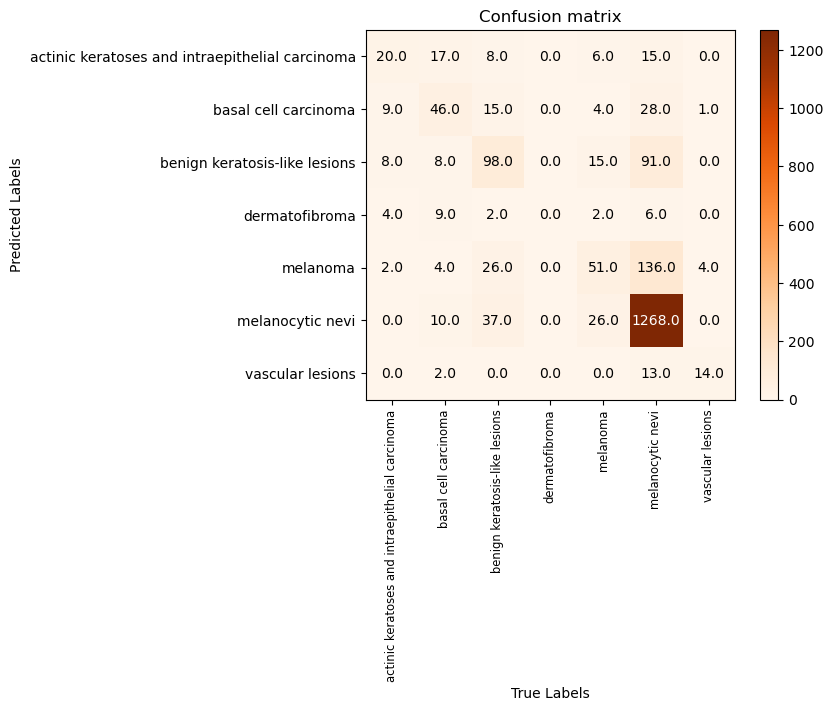

The model accuracy is 0.7466334164588528
+-------------------------------------------------+-----------+--------+-------------+---------+
|                                                 | Presicion | Recall | Specificity | F-score |
+-------------------------------------------------+-----------+--------+-------------+---------+
| actinic keratoses and intraepithelial carcinoma |   0.303   | 0.465  |    0.977    |  0.367  |
|               basal cell carcinoma              |   0.447   | 0.479  |     0.97    |  0.462  |
|          benign keratosis-like lesions          |   0.445   | 0.527  |    0.933    |  0.483  |
|                  dermatofibroma                 |    0.0    |  nan   |    0.989    |   nan   |
|                     melanoma                    |   0.229   |  0.49  |     0.91    |  0.312  |
|                 melanocytic nevi                |   0.946   | 0.814  |    0.837    |  0.875  |
|                 vascular lesions                |   0.483   | 0.737  |    0.992    |

C:\Users\ortiz\AppData\Local\Temp\ipykernel_6656\809079348.py:40: RuntimeWarning:

invalid value encountered in double_scalars



In [23]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


model = model.to(device)

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    test_loss = 0.0
    data_loader = train_loader_at_eval if split == 'train' else test_loader
  
    labels = [label for _,label in n_classes.items()]
    confusion = ConfusionMatrix(len(n_classes) , labels)

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = torch.softmax(model(inputs), dim=1)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            targets = targets.to(torch.int)
            targets = targets.cpu()
            outputs = outputs.cpu()
            confusion.update(torch.argmax(outputs,dim=1),targets.numpy())

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        confusion.plot()
        confusion.summary()
        
        
print('==> Evaluating ...')
#test('train')
test('test')